# **GradCAM and LLM: Unveiling the Secrets of Model Decision-Making.**
This notebook corresponds to the homonymous report and serves as the implementation section of the project. It is structured into six main phases:

- **Model Loading:** The Vit model, created for the project described in the article "[Identifying AI-Generated Art with Deep Learning](https://www.researchgate.net/publication/375116319_Identifying_AI-Generated_Art_with_Deep_Learning)", has been loaded and applied to images from the respective dataset for training and prediction.
  
- **Grad-CAM Application:** Grad-CAM has been applied to a subset of the images of interest derived from the dataset referenced in the article.
  
- **Application of Various LLMs:** LLaVa-NeTx, InstructBLIB, and KOSMOS-2 were employed to generate explanations for points of interest identified by the classifier and represented using GradMap.
  
- **Results Evaluation**
  
- **Results Visualization**


##  *First part: Model Loading*
We will use a Vision Transformer (ViT) model, which, through a fine-tuning phase, has been specialized to classify works of art as either "Original" or "AI-generated."

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
from tqdm import tqdm
import time
import cv2
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
np.random.seed(42)

In [40]:
# Path to your preprocessed dataset (50 Real / 50 Fake)
data_dir = r"C:\Users\Asus\Desktop\Master\Explicabilidad\final-project-joaquinmaciias\dataset_100"

# --- 2. DATA LOADING & PREPROCESSING ---
# ViT requires specific normalization (ImageNet stats) and tensor conversion.
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(), # Augmentation to prevent overfitting on small data
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the entire dataset from the folders 'real' and 'fake'
full_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
class_names = full_dataset.classes
print(f" Classes found: {class_names}")

# Split into 80% Training and 20% Validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to the validation set (technical override)
val_dataset.dataset.transform = data_transforms['val']

# Create DataLoaders to feed batches to the model
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=8, shuffle=True),
    'val': DataLoader(val_dataset, batch_size=8, shuffle=False)
}
dataset_sizes = {'train': train_size, 'val': val_size}
print(f" Dataset split: {train_size} training images, {val_size} validation images.")

 Classes found: ['fake', 'real']
 Dataset split: 80 training images, 20 validation images.


In [45]:
print("Initializing Vision Transformer (ViT)...")

# 1. Load Pretrained ViT Model
# We use IMAGENET1K_V1 weights to leverage features learned from millions of images
model_ft = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

# 2. Freeze Backbone (Transfer Learning)
# We freeze all parameters so we don't destroy pre-trained weights during backprop.
# We only want to train the final classification head.
for param in model_ft.parameters():
    param.requires_grad = False

# 3. Replace Classification Head
# ViT output head is originally 1000 classes (ImageNet). We change it to 2 (Real vs Fake).
num_ftrs = model_ft.heads.head.in_features
model_ft.heads.head = nn.Linear(num_ftrs, 2)

# Move model to the selected device (GPU/CPU)
model_ft = model_ft.to(device)

# --- HYPERPARAMETERS ---

# Loss function: CrossEntropy is standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: We only optimize parameters of the new head (.heads.head.parameters())
# Learning rate is set to 0.001 for stability
optimizer_ft = optim.AdamW(model_ft.heads.head.parameters(), lr=0.001)

# Learning Rate Scheduler: Decays the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# --- TRAINING LOOP FUNCTION ---

def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    print(f"Starting training for {num_epochs} epochs...")

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data (tqdm shows progress bar)
            # We use dataloaders defined in the previous cell
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} phase", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step()

            # Calculate epoch metrics
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'\rEpoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} Accuracy : {epoch_acc:.4f}',end='', flush=True)

            # Deep copy the model if it has the best accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# --- EXECUTE TRAINING ---

# Train the model (5 to 10 epochs is usually enough for this PoC)
trained_model = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

# Save the trained model
save_path = 'model/art_classifier_vit.pth'
torch.save(trained_model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Initializing Vision Transformer (ViT)...
Starting training for 10 epochs...


Epoch 1/10 | Loss: 0.7071 Accuracy : 0.5500

Epoch 1/10 | Loss: 0.5947 Accuracy : 0.8000

Epoch 2/10 | Loss: 0.5155 Accuracy : 0.8125

Epoch 2/10 | Loss: 0.5275 Accuracy : 0.7500

Epoch 3/10 | Loss: 0.3997 Accuracy : 0.9125

Epoch 3/10 | Loss: 0.5069 Accuracy : 0.6500

Epoch 4/10 | Loss: 0.3236 Accuracy : 0.9500

Epoch 4/10 | Loss: 0.4988 Accuracy : 0.7500

Epoch 5/10 | Loss: 0.2682 Accuracy : 0.9750

Epoch 5/10 | Loss: 0.5015 Accuracy : 0.7500

Epoch 6/10 | Loss: 0.2286 Accuracy : 0.9875

Epoch 6/10 | Loss: 0.5068 Accuracy : 0.7500

Epoch 7/10 | Loss: 0.2019 Accuracy : 1.0000

Epoch 7/10 | Loss: 0.5124 Accuracy : 0.7000

Epoch 8/10 | Loss: 0.1796 Accuracy : 1.0000

Epoch 8/10 | Loss: 0.5128 Accuracy : 0.7000

Epoch 9/10 | Loss: 0.1770 Accuracy : 1.0000

Epoch 9/10 | Loss: 0.5126 Accuracy : 0.7000

Epoch 10/10 | Loss: 0.1749 Accuracy : 1.0000

Epoch 10/10 | Loss: 0.5132 Accuracy : 0.7000


Training complete in 3m 24s
Best val Acc: 0.800000
Model saved to model/art_classifier_vit.pth


## *Second part: Visual Explainability with Grad-CAM*

We employ **Grad-CAM (Gradient-weighted Class Activation Mapping)** to interpret the decisions of our fine-tuned Vision Transformer (ViT). Unlike standard CNN implementations, we adapt Grad-CAM to compute the gradients of the target class with respect to the **final normalization layer of the ViT encoder**.

In the context of **AI-generated art detection**, this visualization is critical. It allows us to verify whether the model is focusing on semantically relevant features—such as unnatural brushstrokes, anatomical inconsistencies, or generative artifacts—rather than relying on spurious background correlations. We apply this technique to our **Proof-of-Concept (PoC) validation subset** to qualitatively audit the model's "reasoning" behind classifying an artwork as Real or Fake.

In [46]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.gradients = None
        
    def save_gradient(self, grad):
        """Callback to store gradients."""
        self.gradients = grad

    def forward(self, x):
        """Forward pass ensuring gradients are tracked."""
        self.model.zero_grad()
        if not x.requires_grad:
            x.requires_grad_()
        return self.model(x)

    def generate_cam(self, input_tensor, target_class_idx, target_size=(224, 224)):
        # Forward pass
        output = self.forward(input_tensor)
        
        # Create one-hot target vector
        device = input_tensor.device 
        one_hot = torch.zeros((1, output.size(-1)), device=device)
        one_hot[0][target_class_idx] = 1
        
        # Backward pass
        output.backward(gradient=one_hot)
        
        # Extract data (Gradients & Feature Maps)
        grads = self.gradients.detach().cpu().numpy()
        fmaps = self.model.feature_maps.detach().cpu().numpy()
        
        # Compute weights (Global Average Pooling)
        weights = np.mean(grads, axis=(2, 3))[0, :]
        
        # Weighted Sum (Vectorized)
        # Broadcasting: [C, 1, 1] * [C, H, W] -> Sum axis 0
        cam = np.sum(weights[:, None, None] * fmaps[0], axis=0)
        
        # Post-processing (ReLU -> Resize -> Normalize)
        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, target_size)
        
        cam -= np.min(cam)
        denom = np.max(cam)
        if denom != 0:
            cam /= denom
        
        return cam

In [47]:
class GradCAMPlusPlus:
    def __init__(self, model, target_layers, reshape_transform=None):
        self.model = model
        self.model.eval()
        self.target_layers = target_layers
        self.reshape_transform = reshape_transform
        
        self.gradients = None
        self.activations = None
        
        # Registrar Hooks automáticamente en las capas indicadas
        for layer in self.target_layers:
            layer.register_forward_hook(self.save_activation)
            layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        # Guardamos el gradiente de salida
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, targets=None):
        """
        Interfaz compatible con la librería pytorch-grad-cam.
        Permite llamar a la instancia como cam(...)
        """
        # Extraer índice de clase objetivo (si viene de la librería targets es una lista de objetos)
        target_category = targets[0].category if (targets and hasattr(targets[0], 'category')) else None
        
        # Generar mapa
        cam = self.generate_cam(input_tensor, target_category)
        
        # Devolver con dimensión de batch [1, H, W] para compatibilidad
        return cam[None, :]

    def forward(self, input_tensor):
        self.model.zero_grad()
        return self.model(input_tensor)

    def generate_cam(self, input_tensor, target_category=None):
        # 1. Forward Pass
        output = self.forward(input_tensor)
        
        if target_category is None:
            target_category = np.argmax(output.cpu().data.numpy())
            
        # 2. One-Hot para Backward
        one_hot = torch.zeros_like(output)
        one_hot[0][target_category] = 1
        
        # 3. Backward Pass (Calcular gradientes)
        output.backward(gradient=one_hot, retain_graph=True)
        
        # 4. Obtener Mapas y Gradientes capturados por los hooks
        fmaps = self.activations.detach()
        grads = self.gradients.detach()
        
        # 5. Aplicar Reshape (Crítico para Vision Transformers)
        if self.reshape_transform:
            fmaps = self.reshape_transform(fmaps)
            grads = self.reshape_transform(grads)
            
        fmaps = fmaps.cpu().numpy() # [Batch, C, H, W]
        grads = grads.cpu().numpy() # [Batch, C, H, W]
        
        # --- Lógica Grad-CAM++ ---
        # Trabajamos con el primer elemento del batch
        fmaps = fmaps[0]
        grads = grads[0]
        
        grads_power_2 = grads ** 2
        grads_power_3 = grads ** 3
        
        # Suma de activaciones por canal
        sum_activations = np.sum(fmaps, axis=(1, 2))
        sum_activations = sum_activations[:, None, None]
        
        # Coeficientes Alpha (la magia de GradCAM++)
        eps = 1e-7
        denom = 2 * grads_power_2 + (sum_activations * grads_power_3)
        alpha = grads_power_2 / (denom + eps)
        
        # Pesos w_k^c (Promedio ponderado por alpha y ReLU de gradientes)
        weights = np.sum(alpha * np.maximum(grads, 0), axis=(1, 2))
        
        # 6. Combinación Lineal
        cam = np.sum(weights[:, None, None] * fmaps, axis=0)
        
        # 7. Post-procesado (ReLU + Normalización)
        cam = np.maximum(cam, 0)
        
        # Redimensionar al tamaño de la imagen de entrada
        target_size = (input_tensor.shape[3], input_tensor.shape[2])
        cam = cv2.resize(cam, target_size)
        
        cam -= np.min(cam)
        cam /= (np.max(cam) + 1e-7)
        
        return cam

In [48]:
print("Loading Multimodal VQA Model (BLIP)...")
vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
print("Model loaded!")

# --- INITIALIZE GRAD-CAM (FIXED) ---

# Detect the trained model
if 'trained_model' in globals():
    target_model_for_cam = trained_model
elif 'model_ft' in globals():
    target_model_for_cam = model_ft
else:
    raise ValueError("Error: The trained classifier model is not found.")

# --- RESHAPE TRANSFORM FOR ViT ---
# Transformers do not see images as grids, but as rows of tokens.
# This function converts the row of tokens back into a square image (14x14) for the heatmap.
def reshape_transform(tensor, height=14, width=14):
    # Remove the class token (the first one) and rearrange the rest
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    # Bring channels to the beginning: [Batch, Channels, Height, Width]
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# --- UNFREEZE TARGET LAYER ---
# Select the last normalization layer of the encoder
target_layer = target_model_for_cam.encoder.layers[-1].ln_1

# Force this layer to compute gradients so Grad-CAM works
for param in target_layer.parameters():
    param.requires_grad = True

# Initialize Grad-CAM with the reshape function
cam = GradCAM(model=target_model_for_cam, 
              target_layers=[target_layer], 
              reshape_transform=reshape_transform)

# --- PIPELINE FUNCTIONS ---

def generate_text_explanation(image_tensor, question):
    # De-normalize image
    rgb_img = image_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_img = rgb_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_img = np.clip(rgb_img, 0, 1)
    rgb_img = (rgb_img * 255).astype(np.uint8)
    pil_image = Image.fromarray(rgb_img)
    
    # Ask the model
    inputs = vqa_processor(pil_image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        out = vqa_model.generate(**inputs)
    return vqa_processor.decode(out[0], skip_special_tokens=True)

def full_xai_analysis(index_in_val):
    img_tensor, label = val_dataset[index_in_val]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    true_label = class_names[label]
    
    # VISUAL EXPLANATION
    targets = [ClassifierOutputTarget(label)]
    
    # Generate the map. The reshape_transform is already configured in the 'cam' object
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # PREPARE DISPLAY
    rgb_img = img_tensor.permute(1, 2, 0).numpy()
    rgb_img = rgb_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_img = np.clip(rgb_img, 0, 1)
    
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # TEXTUAL EXPLANATION
    q1 = "Is this image a painting or a photo?"
    q2 = "Describe the artistic style or details."
    q3 = "Is the image realistic?"
    
    ans1 = generate_text_explanation(img_tensor, q1)
    ans2 = generate_text_explanation(img_tensor, q2)
    ans3 = generate_text_explanation(img_tensor, q3)
    
    # PLOT
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(rgb_img)
    axes[0].set_title(f"Ground Truth: {true_label.upper()}")
    axes[0].axis('off')
    
    axes[1].imshow(visualization)
    axes[1].set_title("ViT Attention Map (Grad-CAM)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"MULTIMODAL XAI REPORT (Sample Index: {index_in_val})")
    print("-" * 50)
    print(f"Q: {q1} | A: {ans1}")
    print(f"Q: {q2} | A: {ans2}")
    print(f"Q: {q3} | A: {ans3}")
    print("-" * 50)

Loading Multimodal VQA Model (BLIP)...
Model loaded!


TypeError: GradCAM.__init__() got an unexpected keyword argument 'target_layers'

### Visualization the results

Running Full XAI Analysis on Validation Samples...


c:\Users\Asus\Desktop\Master\Explicabilidad\final-project-joaquinmaciias\.venv\Lib\site-packages\pytorch_grad_cam\base_cam.py:111: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward(retain_graph=True)


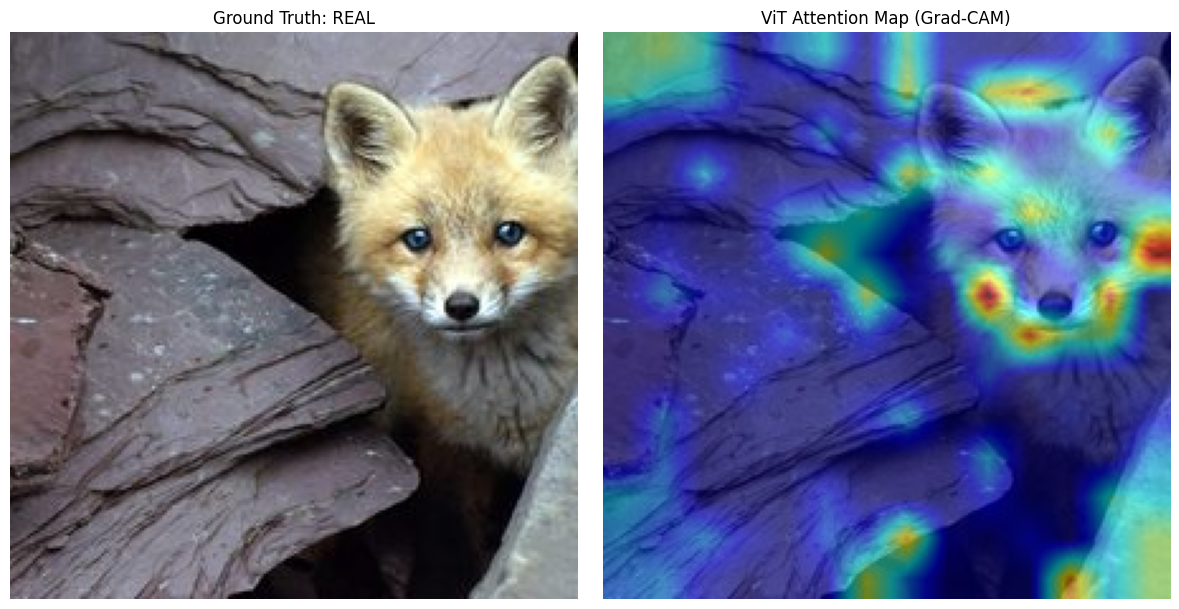

MULTIMODAL XAI REPORT (Sample Index: 1)
--------------------------------------------------
Q: Is this image a painting or a photo? | A: photo
Q: Describe the artistic style or details. | A: modern
Q: Is the image realistic? | A: yes
--------------------------------------------------




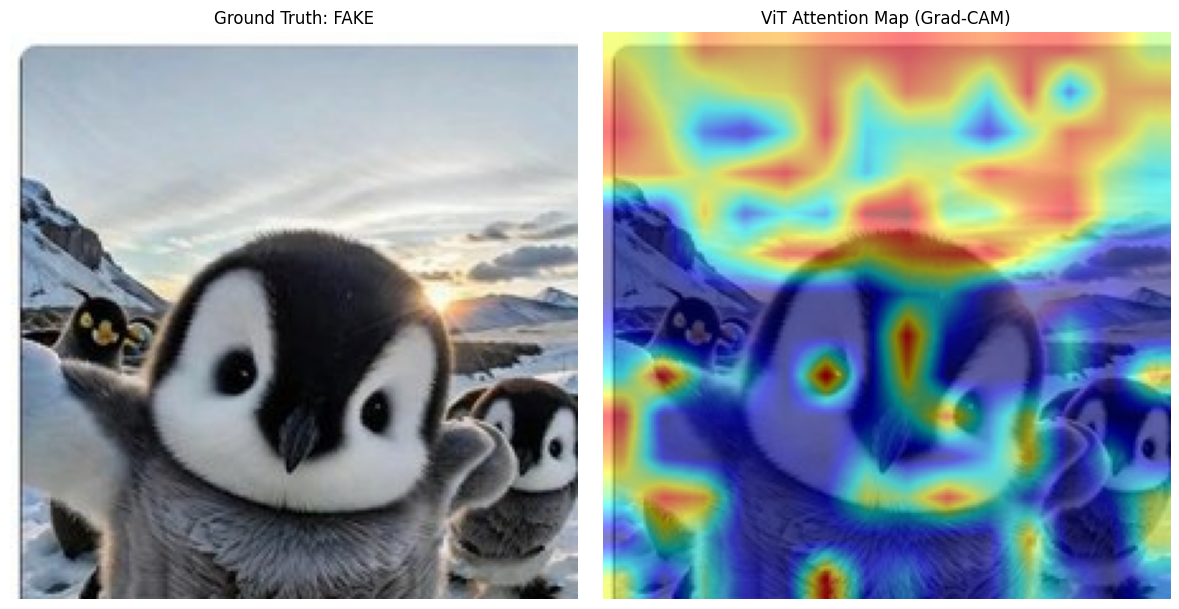

MULTIMODAL XAI REPORT (Sample Index: 2)
--------------------------------------------------
Q: Is this image a painting or a photo? | A: photo
Q: Describe the artistic style or details. | A: modern
Q: Is the image realistic? | A: no
--------------------------------------------------




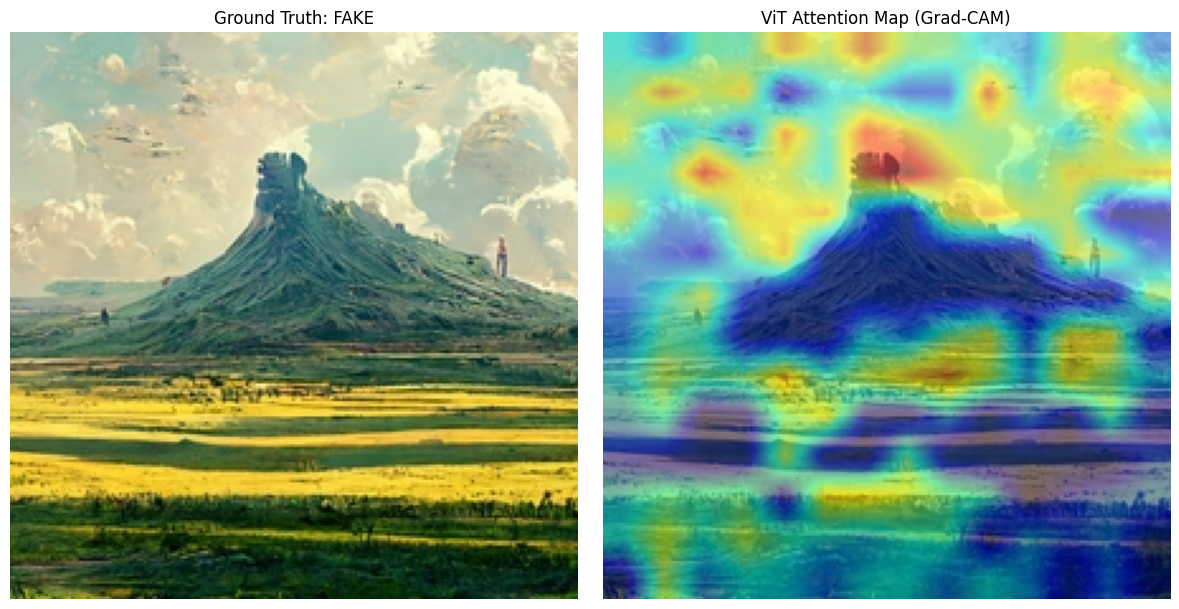

MULTIMODAL XAI REPORT (Sample Index: 10)
--------------------------------------------------
Q: Is this image a painting or a photo? | A: painting
Q: Describe the artistic style or details. | A: landscape
Q: Is the image realistic? | A: no
--------------------------------------------------




In [ ]:
print("Running Full XAI Analysis on Validation Samples...")
indices = [1, 2, 10]

for idx in indices:
    full_xai_analysis(idx)
    print("\n" + "="*60 + "\n")

In [ ]:
print("Loading Multimodal VQA Model (BLIP)...")
vqa_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
vqa_model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base").to(device)
print("Model loaded successfully!")

# --- INITIALIZE GRAD-CAM++ (FIXED) ---

# Detect the trained model
if 'trained_model' in globals():
    target_model_for_cam = trained_model
elif 'model_ft' in globals():
    target_model_for_cam = model_ft
else:
    raise ValueError("Error: The trained classifier model is not found.")

# --- RESHAPE TRANSFORM FOR ViT ---
# Transformers do not see images as grids, but as rows of tokens.
# This function converts the row of tokens back into a square image (14x14) for the heatmap.
def reshape_transform(tensor, height=14, width=14):
    # Remove the class token (the first one) and rearrange the rest
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    # Bring channels to the beginning: [Batch, Channels, Height, Width]
    result = result.transpose(2, 3).transpose(1, 2)
    return result

# --- UNFREEZE TARGET LAYER ---
# Select the last normalization layer of the encoder
target_layer = target_model_for_cam.encoder.layers[-1].ln_1

# Force this layer to compute gradients so Grad-CAM works
for param in target_layer.parameters():
    param.requires_grad = True

# --- CHANGE 2: Initialize Grad-CAM++ ---
# We use GradCAMPlusPlus class which handles higher-order derivatives
print("Initializing Grad-CAM++...")
cam = GradCAMPlusPlus(model=target_model_for_cam, 
                      target_layers=[target_layer], 
                      reshape_transform=reshape_transform)

# --- PIPELINE FUNCTIONS ---

def generate_text_explanation(image_tensor, question):
    # De-normalize image
    rgb_img = image_tensor.permute(1, 2, 0).cpu().numpy()
    rgb_img = rgb_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_img = np.clip(rgb_img, 0, 1)
    rgb_img = (rgb_img * 255).astype(np.uint8)
    pil_image = Image.fromarray(rgb_img)
    
    # Ask the model
    inputs = vqa_processor(pil_image, question, return_tensors="pt").to(device)
    with torch.no_grad():
        out = vqa_model.generate(**inputs)
    return vqa_processor.decode(out[0], skip_special_tokens=True)

def full_xai_analysis(index_in_val):
    img_tensor, label = val_dataset[index_in_val]
    input_tensor = img_tensor.unsqueeze(0).to(device)
    true_label = class_names[label]
    
    # VISUAL EXPLANATION
    targets = [ClassifierOutputTarget(label)]
    
    # Generate the map. The reshape_transform is already configured in the 'cam' object
    # Note: GradCAM++ might generate slightly different heatmaps focusing on multiple object parts
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
    
    # PREPARE DISPLAY
    rgb_img = img_tensor.permute(1, 2, 0).numpy()
    rgb_img = rgb_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    rgb_img = np.clip(rgb_img, 0, 1)
    
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    
    # TEXTUAL EXPLANATION
    q1 = "Is this image a painting or a photo?"
    q2 = "Describe the artistic style or details."
    q3 = "Is the image realistic?"
    
    ans1 = generate_text_explanation(img_tensor, q1)
    ans2 = generate_text_explanation(img_tensor, q2)
    ans3 = generate_text_explanation(img_tensor, q3)
    
    # PLOT
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    axes[0].imshow(rgb_img)
    axes[0].set_title(f"Ground Truth: {true_label.upper()}")
    axes[0].axis('off')
    
    axes[1].imshow(visualization)
    axes[1].set_title("ViT Attention Map (Grad-CAM++)") # Updated title
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"MULTIMODAL XAI REPORT (Sample Index: {index_in_val})")
    print("-" * 50)
    print(f"Q: {q1} | A: {ans1}")
    print(f"Q: {q2} | A: {ans2}")
    print(f"Q: {q3} | A: {ans3}")
    print("-" * 50)

Loading Multimodal VQA Model (BLIP)...
Model loaded successfully!
Initializing Grad-CAM++...


Running Full XAI Analysis (Grad-CAM++) on Validation Samples...


C:\Users\Asus\AppData\Local\Temp\ipykernel_25088\3016952944.py:53: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(gradient=one_hot, retain_graph=True)


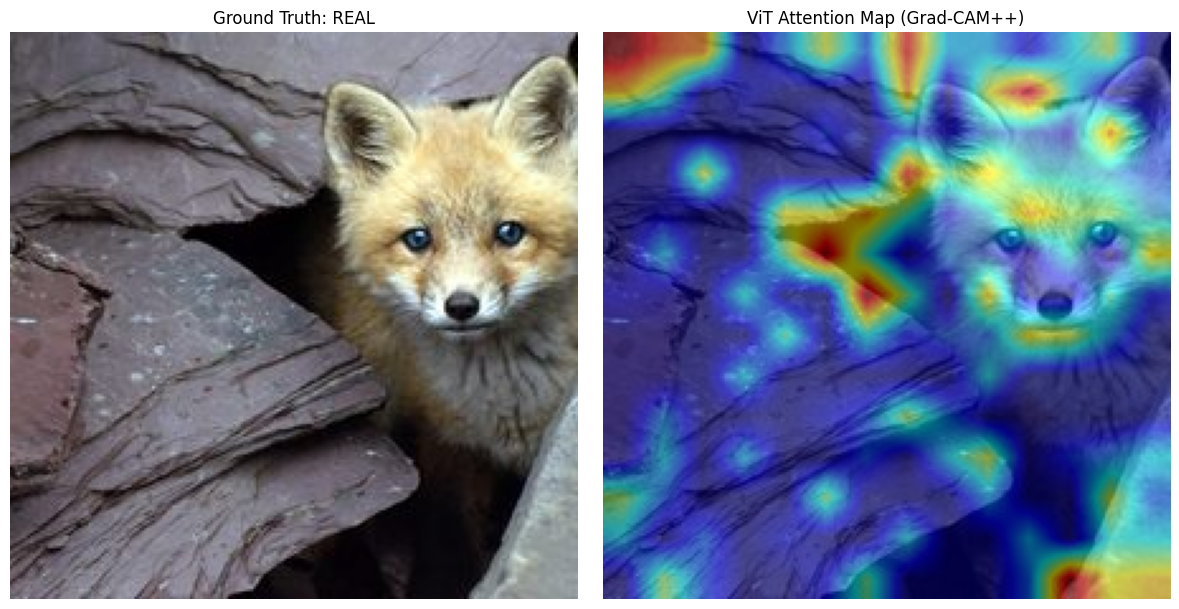

MULTIMODAL XAI REPORT (Sample Index: 1)
--------------------------------------------------
Q: Is this image a painting or a photo? | A: photo
Q: Describe the artistic style or details. | A: modern
Q: Is the image realistic? | A: yes
--------------------------------------------------




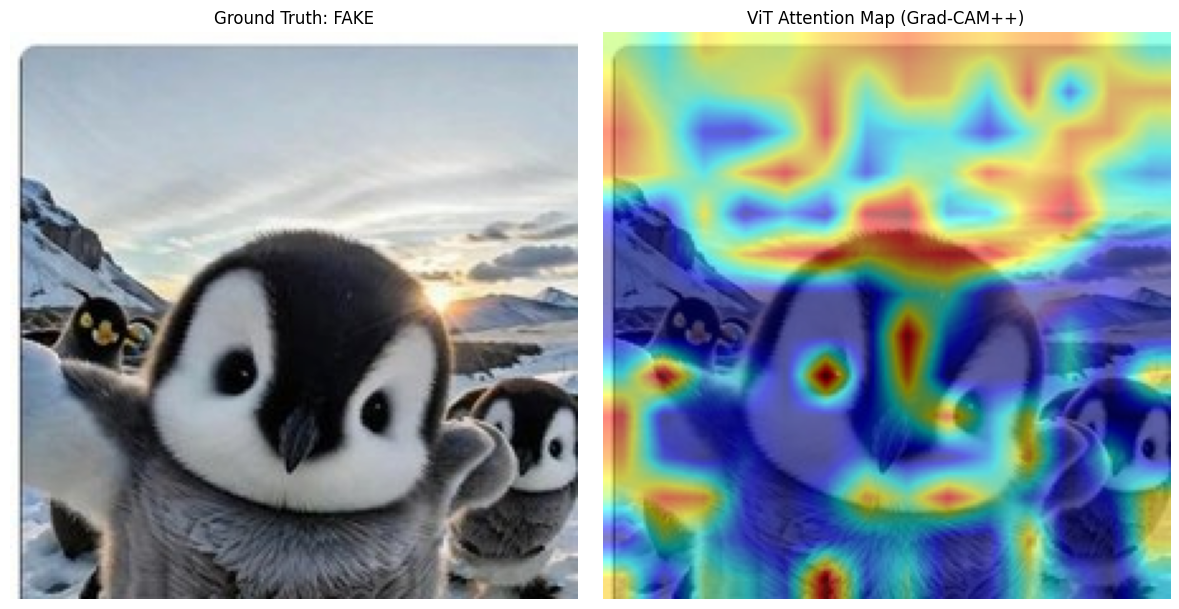

MULTIMODAL XAI REPORT (Sample Index: 2)
--------------------------------------------------
Q: Is this image a painting or a photo? | A: photo
Q: Describe the artistic style or details. | A: modern
Q: Is the image realistic? | A: no
--------------------------------------------------




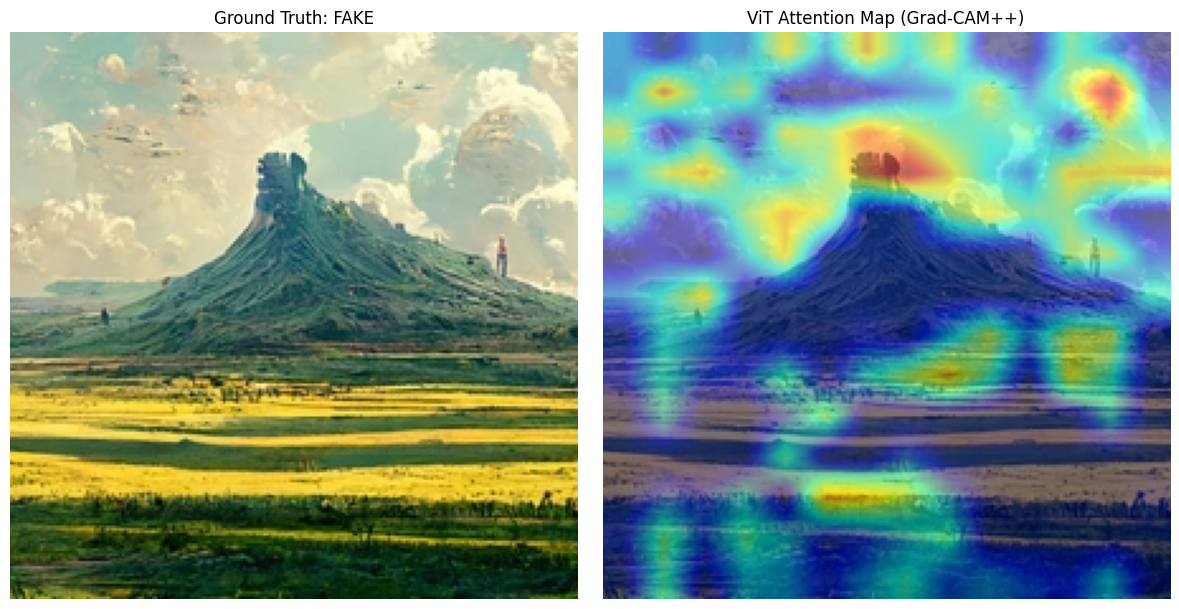

MULTIMODAL XAI REPORT (Sample Index: 10)
--------------------------------------------------
Q: Is this image a painting or a photo? | A: painting
Q: Describe the artistic style or details. | A: landscape
Q: Is the image realistic? | A: no
--------------------------------------------------




In [ ]:
# --- EXECUTION ---
print("Running Full XAI Analysis (Grad-CAM++) on Validation Samples...")
# Use random indices to test on different images
indices = [1, 2, 10]

for idx in indices:
    full_xai_analysis(idx)
    print("\n" + "="*60 + "\n")